In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2



In [24]:
%cd /content/drive/MyDrive
!unzip archive.zip -d dataEmotion

Streaming output truncated to the last 5000 lines.
  inflating: dataEmotion/archive/train/sad/Training_10091569.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10094936.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10115766.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10235859.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10444028.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10576214.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10643239.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10665136.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10842325.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11106902.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11112803.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11213631.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11324743.jpg  
  inflating: dataEmotion/archive/train/sad/Training_1143303.jpg  
  inflating:

In [25]:
train_dir = '/content/drive/MyDrive/dataEmotion/archive/train/'
val_dir = '/content/drive/MyDrive/dataEmotion/archive/test/'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
val_Count = Classes_Count(val_dir, 'val').transpose().sort_values(by="val", ascending=False)

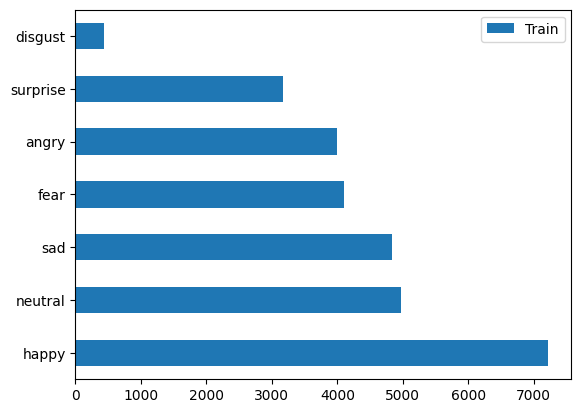

In [ ]:
Train_Count.plot(kind='barh')

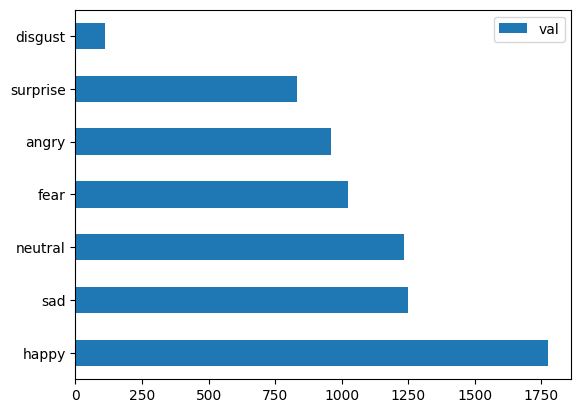

In [26]:
val_Count.plot(kind='barh')

In [27]:
img_shape = 48
batch_size = 64
train_data_path = '/content/drive/MyDrive/dataEmotion/archive/train/'
val_data_path = '/content/drive/MyDrive/dataEmotion/archive/test/'

In [28]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


val_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb', 
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)


val_data = val_preprocessor.flow_from_directory(
    val_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [35]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(48,48,3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

ResNet50V2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [36]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False



In [37]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model



In [38]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 dropout_6 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 2, 2, 2048)       8192      
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                524352    
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                      

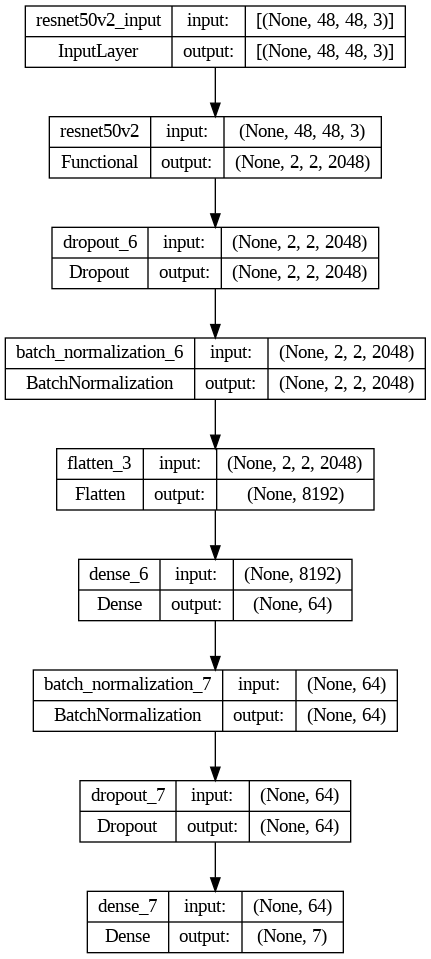

In [39]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(ResNet50V2_Model, to_file='ResNet50V2_Architecture.png', show_shapes=True,show_layer_names=True)
Image(filename='ResNet50V2_Architecture.png') 

In [40]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = val_data.n // val_data.batch_size

In [41]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = val_data , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/30
448/448 [==============================] - 128s 260ms/step - loss: 1.9773 - accuracy: 0.3171 - val_loss: 2.5584 - val_accuracy: 0.3809 - lr: 0.0010
Epoch 2/30
448/448 [==============================] - 114s 254ms/step - loss: 1.6456 - accuracy: 0.3943 - val_loss: 1.6717 - val_accuracy: 0.4150 - lr: 0.0010
Epoch 3/30
448/448 [==============================] - 113s 252ms/step - loss: 1.5856 - accuracy: 0.4108 - val_loss: 1.4027 - val_accuracy: 0.4676 - lr: 0.0010
Epoch 4/30
448/448 [==============================] - 115s 257ms/step - loss: 1.5114 - accuracy: 0.4423 - val_loss: 1.3924 - val_accuracy: 0.4763 - lr: 0.0010
Epoch 5/30
448/448 [==============================] - 118s 263ms/step - loss: 1.4706 - accuracy: 0.4528 - val_loss: 1.3894 - val_accuracy: 0.4807 - lr: 0.0010
Epoch 6/30
448/448 [==============================] - 112s 249ms/step - loss: 1.4335 - accuracy: 0.4651 - val_loss: 1.3788 - val_accuracy: 0.4824 - lr: 0.0010
Epoch 7/30
448/448 [==========================

In [42]:
%cd /content/drive/MyDrive/Emotion_Detection_VGG16
import pandas as pd


# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(ResNet50V2_history.history) 

# or save to csv: 
hist_csv_file = 'historyResnetBase_au.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

/content/drive/MyDrive/Emotion_Detection_VGG16


In [ ]:
%cd /content/drive/MyDrive/Emotion_Detection_VGG16
ResNet50V2_Model.save('modelResNet50V2.h5') 

/content/drive/MyDrive/Emotion_Detection_VGG16


In [21]:
from keras.models import load_model

In [22]:
ResNet50V2_Model = load_model('/content/drive/MyDrive/Emotion_Detection_VGG16/modelResNet50V2.h5')

In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(val_data)

print("Val Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Val Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

In [43]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    

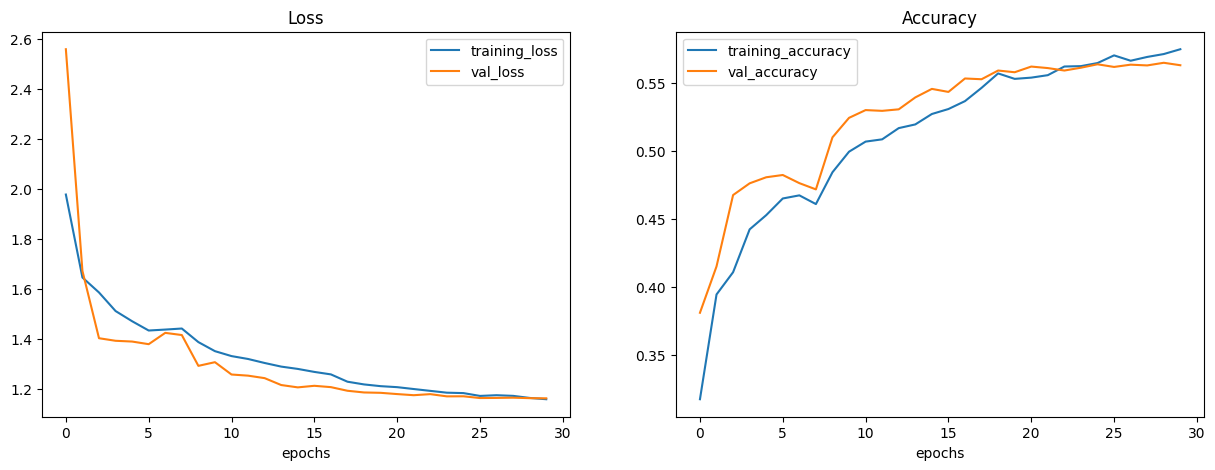

In [44]:
plot_curves(ResNet50V2_history)

In [ ]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(val_data)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)



113/113 [==============================] - 40s 348ms/step


<Figure size 640x480 with 0 Axes>

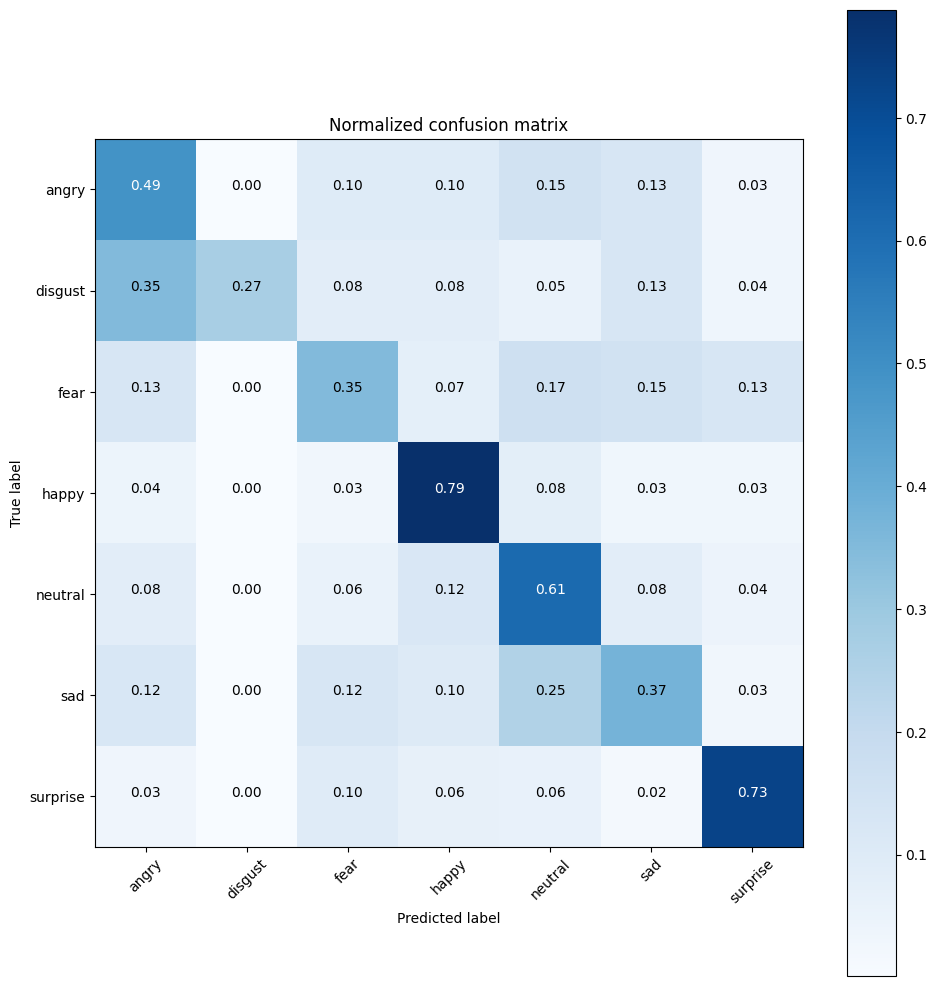

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(val_data.labels, ResNet50V2_Predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=val_data.class_indices.keys(), title='Normalized confusion matrix')
plt.show()

